Content

- [Data Reshaping and Preprocessing](seq2seq.ipynb)
- [2Layered seq2seq multivariate](seq2seq.ipynb)
    - [Preditcion & Evaluation]()
- [2Layered seq2seq multivariate different shape](seq2seq.ipynb)
    - [Preditcion & Evaluation]()
- [1Layered seq2seq univariate](seq2seq.ipynb)
    - [Preditcion & Evaluation]()

For this file the goal was the same as the first one to predict using 1day info backwards to next Hour for the prices of each state, but i proposed other type of models which are : 

-2layered sequence to sequence encoder decoder model using GRU and LSTM that is for multivariate task

-1layered sequence to sequence encoder decoder model using GRU and LSTM that is for univariate task


The file contains a seq2seq multivariate model that takes all 5 time series as input and predict all 5 series at once with 2 layers GRU

The file also contains the same model used with different shape 

And contains a reduced form of the seq2seq model for univariate task for the first state as an example to see the performance along with graphs

Also used Early stopping to avoid the  overfitting of the network and also used a schedule to reduce  learning rate during training

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import warnings
from tensorflow.keras.callbacks import EarlyStopping
# Ignore all warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
df=pd.read_csv("data.csv")
df.index = pd.to_datetime(df.date_time)
df = df.drop("date_time",axis=1)
df = df.iloc[:,1::2]
df____1 = pd.DataFrame(df.iloc[:,1])
df.head(2)

,price_new_south_wales,price_queensland,price_south_australia,price_tasmania,price_victoria
date_time,,,,,
2023-01-01 00:05:00,140.40,139.73,127.57,450.10,129.51
2023-01-01 00:10:00,133.96,136.00,122.85,117.44,124.72


In [3]:
df____1.head(2)

,price_queensland
date_time,
2023-01-01 00:05:00,139.73
2023-01-01 00:10:00,136.00


In [32]:
train_df,test_df = df[:int(len(df)*0.75)], df[int(len(df)*0.75):] 

<p style="text-align:center; font-size:24px; font-weight:bold;">MinMax scaling</p>

In [7]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [34]:
train_df.head(2)

,price_new_south_wales,price_queensland,price_south_australia,price_tasmania,price_victoria
date_time,,,,,
2023-01-01 00:05:00,0.064795,0.031203,0.064013,0.087778,0.072515
2023-01-01 00:10:00,0.064429,0.030968,0.063745,0.067615,0.072206


<p style="text-align:center; font-size:24px; font-weight:bold;">Reshaping</p>

In [8]:
def split_series(series, n_past, n_future):
    
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [36]:
n_past = 288
n_future = 12 
n_features = 5

In [37]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [9]:
y_train.shape

(78541, 12, 5)

<p style="text-align:center; font-size:24px; font-weight:bold;">Model Architecture</p>

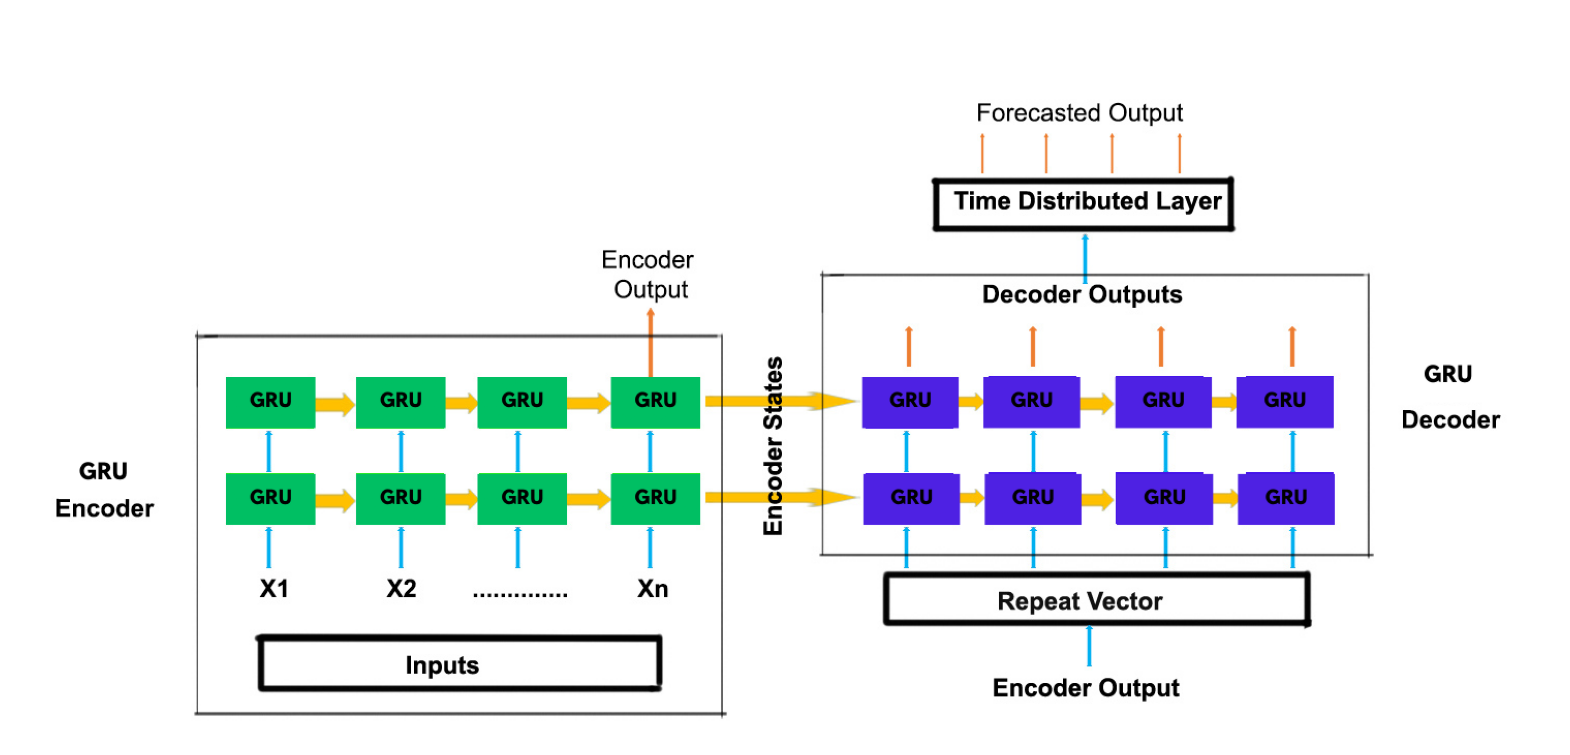

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'path/to/image.png' with the actual path to your image file
image_path = 'seqtoseq.png'

# Load and plot the image with adjusted figure size
img = mpimg.imread(image_path)

# Adjust the figure size
plt.figure(figsize=(20, 15))  # Change the size as needed
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [10]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.GRU(64,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.GRU(32, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.GRU(64, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.GRU(32, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 5)    │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru (GRU)           │ [(None, 288, 64), │  13,632 │ input_layer[0][0]    │
│                     │ (None, 64)]       │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru_1 (GRU)         │ [(None, 32),      │   9,408 │ gru[0][0]            │
│                     │ (None, 32)]       │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ repeat_vector       │ (None, 12, 32)    │       0 │ gru_1[0][0]          │
│ (RepeatVector)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru_2 (GRU)         │ (None, 12, 64)    │  18,816 │ repeat_vector[0][0], │
│                     │                   │         │ gru[0][1]            │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru_3 (GRU)         │ (None, 12, 32)    │   9,408 │ gru_2[0][0],         │
│                     │                   │         │ gru_1[0][1]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ time_distributed    │ (None, 12, 5)     │     165 │ gru_3[0][0]          │
│ (TimeDistributed)   │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 51,429 (200.89 KB)

 Trainable params: 51,429 (200.89 KB)

 Non-trainable params: 0 (0.00 B)

<p style="text-align:center; font-size:24px; font-weight:bold;">2Layered multivariate Model</p>

In [11]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr,EarlyStopping(monitor="val_loss", patience=4)])

Epoch 1/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 523s 208ms/step - loss: 1.3719e-04 - val_loss: 8.3440e-05 - learning_rate: 0.0010
Epoch 2/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 554s 226ms/step - loss: 1.3127e-04 - val_loss: 8.6505e-05 - learning_rate: 9.0000e-04
Epoch 3/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 495s 201ms/step - loss: 1.3100e-04 - val_loss: 8.5999e-05 - learning_rate: 8.1000e-04
Epoch 4/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 502s 204ms/step - loss: 1.3069e-04 - val_loss: 8.4638e-05 - learning_rate: 7.2900e-04
Epoch 5/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 505s 206ms/step - loss: 1.3325e-04 - val_loss: 8.1415e-05 - learning_rate: 6.5610e-04
Epoch 6/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 539s 219ms/step - loss: 1.1770e-04 - val_loss: 8.3274e-05 - learning_rate: 5.9049e-04
Epoch 7/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 540s 220ms/step - loss: 1.2650e-04 - val_loss: 8.0773e-05 - learning_rate: 5.3144e-04
Epoch 8/10
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 550s 224ms/step - loss: 1.1771e-04 - val_loss: 7.9288e-05 - learni

<p style="text-align:center; font-size:24px; font-weight:bold;">Prediction</p>

In [13]:
pred_e2d2=model_e2d2.predict(X_test)

812/812 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step


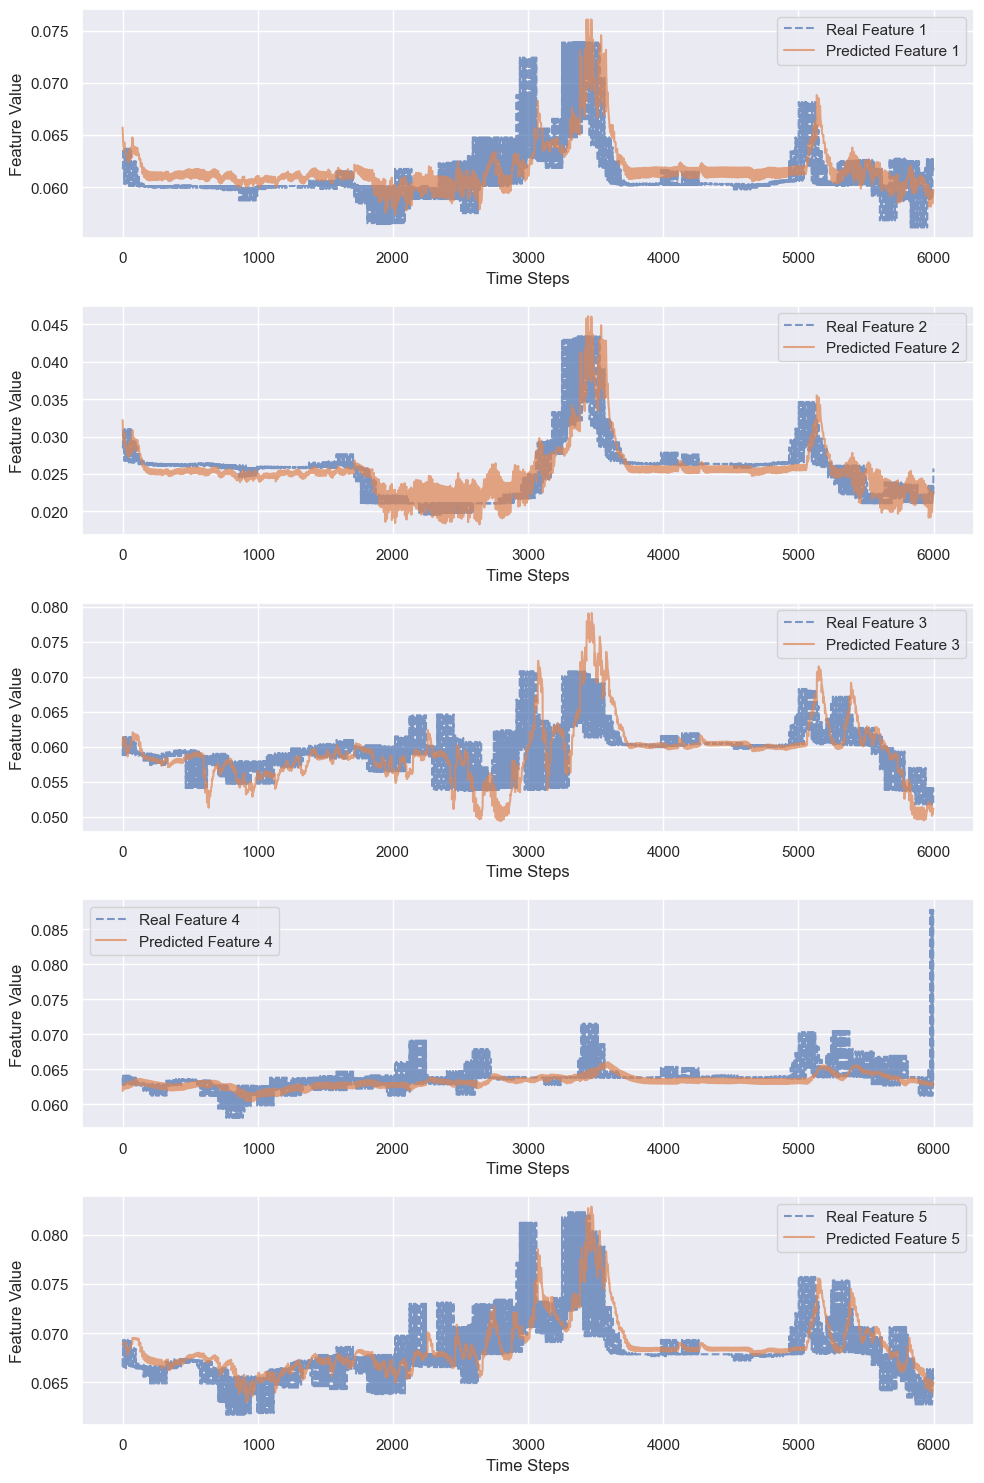

In [19]:
num_features = y_test.shape[-1]

# Create subplots for each feature with overlapping plots
fig, axs = plt.subplots(num_features, 1, figsize=(10, num_features * 3))

# Iterate over each feature and plot real and predicted values overlapping
for i in range(num_features):
    axs[i].plot(y_test[:500, :, i].flatten(), label=f'Real Feature {i+1}', linestyle='--', alpha=0.7)
    axs[i].plot(pred_e2d2[:500, :, i].flatten(), label=f'Predicted Feature {i+1}', linestyle='-', alpha=0.7)
    axs[i].set_xlabel('Time Steps')
    axs[i].set_ylabel('Feature Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [15]:
# for index,i in enumerate(train_df.columns):
#     scaler = scalers['scaler_'+i]
#     pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
#     pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
#     y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
#     y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

<p style="text-align:center; font-size:24px; font-weight:bold;">MSE</p>

In [17]:
from sklearn.metrics import mean_squared_error
for index,i in enumerate(train_df.columns):
  print(i)
  print("MSE-E2D2 : ",mean_squared_error(y_test[:,:,index],pred_e2d2[:,:,index]))
  print()
  print()

price_new_south_wales
MSE-E2D2 :  0.00011835934863807056


price_queensland
MSE-E2D2 :  0.00036045319190662075


price_south_australia
MSE-E2D2 :  0.00031212342344376826


price_tasmania
MSE-E2D2 :  3.21777855449937e-06


price_victoria
MSE-E2D2 :  5.668717739362306e-06




<p style="text-align:center; font-size:24px; font-weight:bold;">Reshape</p>
<p style="text-align:center;;">Tried using a different shape just inverting the channels 288,1 ==> 1,288 it should train faster and has the same as the first shape ie 1day backward and 1H future</p>

In [38]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0],n_features, X_train.shape[1]))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0],n_features, X_test.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [39]:
X_train.shape

(78541, 5, 288)

In [41]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=64,verbose=1,callbacks=[reduce_lr,EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 2.0092e-04 - val_loss: 1.0352e-04 - learning_rate: 0.0010
Epoch 2/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 1.2638e-04 - val_loss: 8.4973e-05 - learning_rate: 9.0000e-04
Epoch 3/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 1.2573e-04 - val_loss: 8.7639e-05 - learning_rate: 8.1000e-04
Epoch 4/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 1.2408e-04 - val_loss: 9.3003e-05 - learning_rate: 7.2900e-04
Epoch 5/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 1.3576e-04 - val_loss: 8.8611e-05 - learning_rate: 6.5610e-04
Epoch 6/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 1.2624e-04 - val_loss: 8.1747e-05 - learning_rate: 5.9049e-04
Epoch 7/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 1.2156e-04 - val_loss: 8.1802e-05 - learning_rate: 5.3144e-04
Epoch 8/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 1.1897e-04 - val_loss: 8.2824e-05 - learning_rate:

In [42]:
pred_e2d2=model_e2d2.predict(X_test)

812/812 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


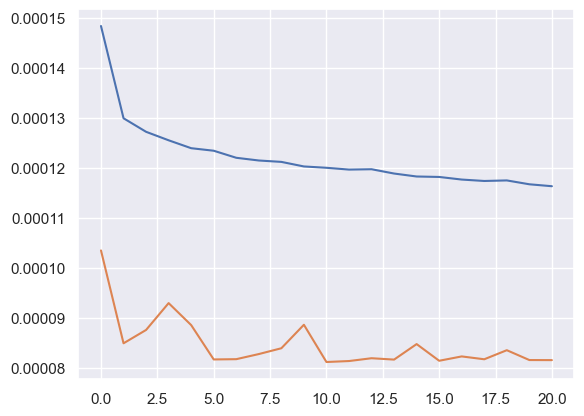

In [43]:
plt.plot(history_e2d2.history["loss"])
plt.plot(history_e2d2.history["val_loss"])

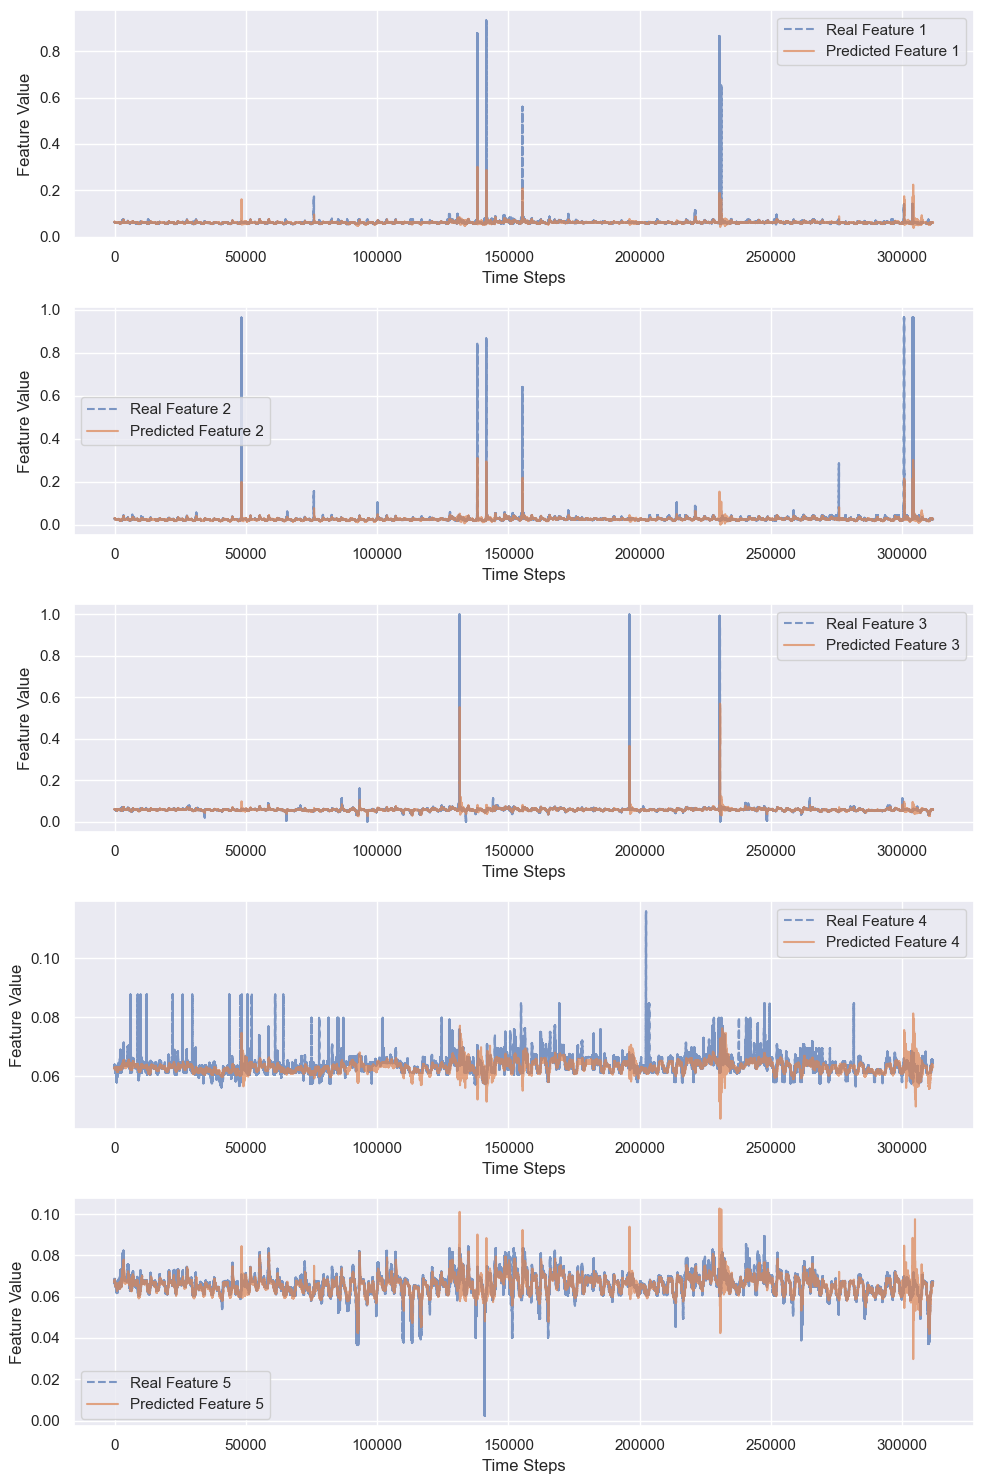

In [61]:
num_features = y_test.shape[-1]

# Create subplots for each feature with overlapping plots
fig, axs = plt.subplots(num_features, 1, figsize=(10, num_features * 3))

# Iterate over each feature and plot real and predicted values overlapping
for i in range(num_features):
    axs[i].plot(y_test[:int(len(df)/2),:,i].flatten(), label=f'Real Feature {i+1}', linestyle='--', alpha=0.7)
    axs[i].plot(pred_e2d2[:int(len(df)/2),:,i].flatten(), label=f'Predicted Feature {i+1}', linestyle='-', alpha=0.7)
    axs[i].set_xlabel('Time Steps')
    axs[i].set_ylabel('Feature Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:24px; font-weight:bold;">1Layered Univariate model</p>

In [5]:
train_df,test_df = df____1[:int(len(df____1)*0.75)], df____1[int(len(df____1)*0.75):] 

In [6]:
n_past = 288
n_future = 12 
n_features = 1

In [9]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0],n_features, X_train.shape[1]))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0],n_features, X_test.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [13]:
encoder_inputs = tf.keras.layers.Input(shape=( n_features,n_past))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 288)    │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_2 (LSTM)       │ [(None, 100),     │ 155,600 │ input_layer_1[0][0]  │
│                     │ (None, 100),      │         │                      │
│                     │ (None, 100)]      │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ repeat_vector_1     │ (None, 12, 100)   │       0 │ lstm_2[0][0]         │
│ (RepeatVector)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_3 (LSTM)       │ (None, 12, 100)   │  80,400 │ repeat_vector_1[0][… │
│                     │                   │         │ lstm_2[0][1],        │
│                     │                   │         │ lstm_2[0][2]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ time_distributed_1  │ (None, 12, 1)     │     101 │ lstm_3[0][0]         │
│ (TimeDistributed)   │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 236,101 (922.27 KB)

 Trainable params: 236,101 (922.27 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=64,verbose=1,callbacks=[reduce_lr,EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 2.5184e-04 - val_loss: 1.7615e-04 - learning_rate: 0.0010
Epoch 2/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 2.3244e-04 - val_loss: 1.7822e-04 - learning_rate: 9.0000e-04
Epoch 3/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 2.2967e-04 - val_loss: 1.7431e-04 - learning_rate: 8.1000e-04
Epoch 4/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 2.2164e-04 - val_loss: 1.7557e-04 - learning_rate: 7.2900e-04
Epoch 5/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 2.1625e-04 - val_loss: 1.7763e-04 - learning_rate: 6.5610e-04
Epoch 6/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 2.1590e-04 - val_loss: 1.7568e-04 - learning_rate: 5.9049e-04
Epoch 7/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 2.1172e-04 - val_loss: 1.7458e-04 - learning_rate: 5.3144e-04
Epoch 8/100
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 2.0614e-04 - val_loss: 1.7414e-04 - learning_rate:

In [15]:
pred_e1d1=model_e1d1.predict(X_test)

812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


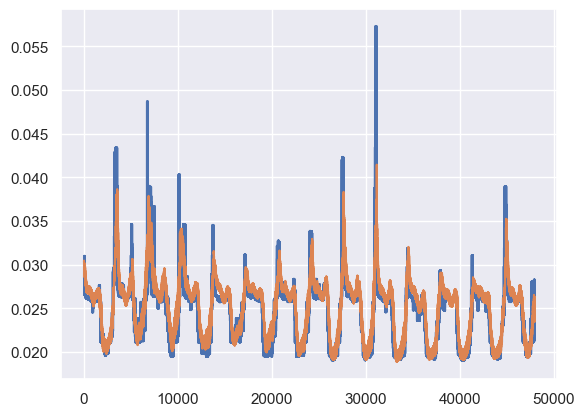

In [32]:
plt.plot(y_test[:4000].flatten())
plt.plot(pred_e1d1[:4000].flatten());

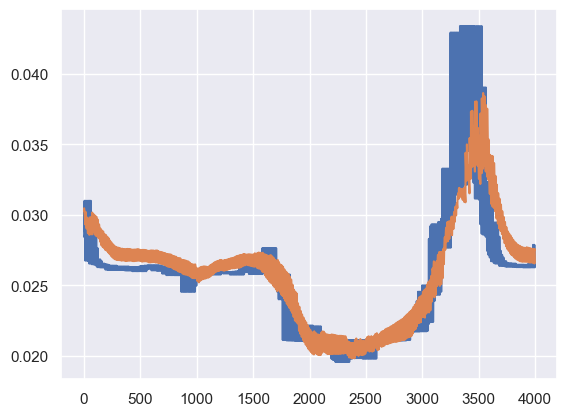

In [30]:
plt.plot(y_test.flatten()[:4000])
plt.plot(pred_e1d1.flatten()[:4000]);